In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt 
import shapely as shp
import os, sys
from tqdm import tqdm
sys.path.append('../scripts/')
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
path_dict = loadpaths.loadpaths()


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# TMP

In [34]:
from dissolve_predictions import dissolve_predicted_tiles, save_area_threshold_dict


In [68]:
tmp = dissolve_predicted_tiles(test_run=True,
                               use_class_dependent_area_thresholds=True,
                               file_path_class_dependent_area_thresholds='../content/area_threshold_combinations/th-combi-2023-08-22.json')
# tmp[1].plot(column='class', legend=True)

Using class-dependent area thresholds from th-combi-2023-08-22
adding scrub
splitting up heath
adding wetland
adding transport
Found 1617 tiles
Running test run with 5 tiles


Dissolving tiles, iteration 0: : 0it [00:00, ?it/s]

LCU_detailed-combined_SK1561_LC-prediction


1662it [00:15, 105.42it/s]
../scripts/land_cover_analysis.py:1809: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  continue_dissolving = False
121it [00:00, 196.66it/s]
../scripts/land_cover_analysis.py:1809: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  continue_dissolving = False
25it [00:00, 136.59it/s]
../scripts/land_cover_analysis.py:1809: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  continue_dissolving = False
25it [00:00, 36.10it/s]
../scripts/land_cover_ana

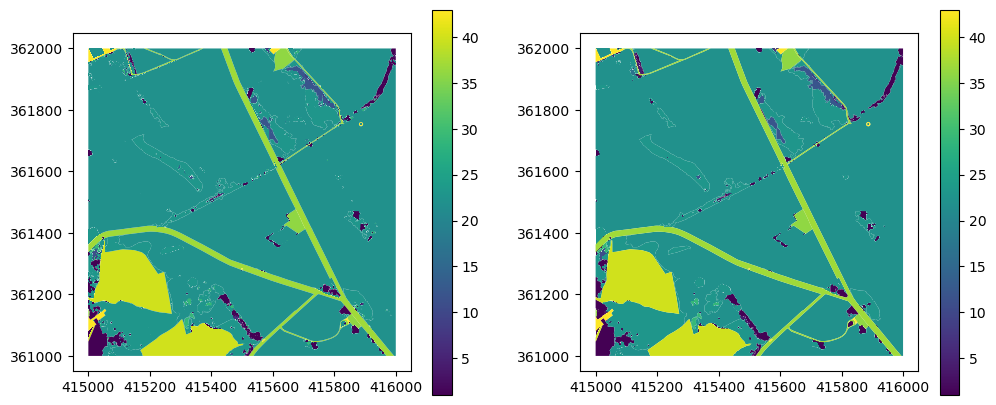

In [89]:

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
tmp[0].plot(ax=ax[0], column='class', legend=True)
tmp[1].plot(ax=ax[1], column='class', legend=True)
# ax[1].set_xlim([415010, 415020])
# ax[1].set_ylim([361090, 361100])

# Continue

In [17]:
df_tmp = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/tiles_qr/tiles_qr.shp')
# df_tmp[df_tmp['PLAN_NO'] == 'SK2292']
print(len(df_tmp), len(df_tmp['PLAN_NO'].unique()))
df_tmp = df_tmp.drop(columns=['lc_label', 'id_pol', 'keep_h2a'])
df_improved = df_tmp.drop_duplicates(subset=['PLAN_NO'])
len(df_tmp), len(df_improved)

234 152


(234, 152)

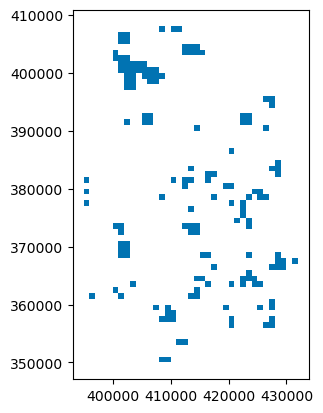

In [18]:
df_tmp['geometry'].plot()

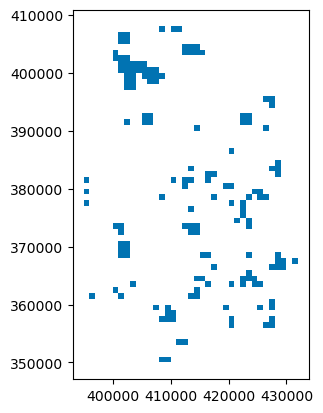

In [20]:
df_improved['geometry'].plot()

In [21]:
df_improved.to_file('/home/tplas/repos/cnn-land-cover/content/tiles_qr/tiles_qr.shp')

# Create FGH layer without false quarries

In [4]:
tmp_path = '/home/tplas/data/gis/tmp_fgh_layer_quarries_removed/tmp_fgh_layer_qr.shp' 
df_fgh_qr = gpd.read_file(tmp_path)
df_qr = df_fgh_qr[np.logical_and(df_fgh_qr['keep_h2a'] == 0, 
                                  df_fgh_qr['lc_label'] == 'H2a')]
df_qr

,lc_label,id_pol,keep_h2a,geometry
9460,H2a,9461,0,"POLYGON ((409050.480 350157.190, 409051.326 35..."
9461,H2a,9462,0,"POLYGON ((409401.690 357513.700, 409400.410 35..."
9462,H2a,9463,0,"POLYGON ((409042.640 358023.990, 409049.300 35..."
9464,H2a,9465,0,"POLYGON ((409395.390 358789.390, 409392.740 35..."
9465,H2a,9466,0,"POLYGON ((409399.980 359218.250, 409388.110 35..."
...,...,...,...,...
9751,H2a,9752,0,"POLYGON ((427434.500 383735.000, 427422.000 38..."
9753,H2a,9754,0,"POLYGON ((426757.420 390884.470, 426757.420 39..."
9754,H2a,9755,0,"POLYGON ((427919.200 394492.160, 427919.250 39..."
9755,H2a,9756,0,"POLYGON ((427480.610 394871.920, 427481.670 39..."


In [5]:
df_fgh_new = df_fgh_qr[np.logical_or(df_fgh_qr['keep_h2a'] == 1,
                                        df_fgh_qr['lc_label'] != 'H2a')]

In [8]:
df_dfgh_original = lca.load_pols('/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp')
df_dfgh_original.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [9]:
df_fgh_new = df_fgh_new.drop(columns=['keep_h2a', 'id_pol'])
df_fgh_new.crs = df_dfgh_original.crs
df_fgh_new

,lc_label,geometry
0,F2,"POLYGON ((400841.890 360432.090, 400841.600 36..."
1,F2,"POLYGON ((399308.710 360858.520, 399311.100 36..."
2,F2,"POLYGON ((398209.238 361574.805, 398211.921 36..."
3,F2,"POLYGON ((399679.571 362509.906, 399682.710 36..."
4,F2,"POLYGON ((397708.580 363577.710, 397708.910 36..."
...,...,...
18051,H3b,"POLYGON ((427553.290 395338.570, 427552.560 39..."
18052,H3b,"POLYGON ((427769.030 395617.170, 427771.450 39..."
18053,H3b,"POLYGON ((427765.920 395621.030, 427765.720 39..."
18054,H3b,"POLYGON ((427845.770 395627.500, 427844.170 39..."


In [10]:
assert len(df_fgh_new) + len(df_qr) == len(df_fgh_qr)
assert df_fgh_new.crs != None
print(len(df_fgh_new[df_fgh_new['lc_label'] == 'H2a']))
os.makedirs('/home/tplas/data/gis/fgh_layer_v2/', exist_ok=True)
df_fgh_new.to_file('/home/tplas/data/gis/fgh_layer_v2/fgh_layer_v2.shp')

140


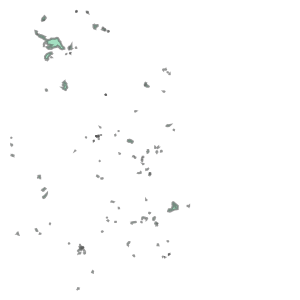

In [14]:
df_qr.unary_union

In [15]:
df_tile_outlines = lca.load_pols(path_dict['landscape_character_grid_path'])

## find intersecting tiles with df_qr 
df_tiles_qr = gpd.sjoin(df_tile_outlines, df_qr, how='inner', op='intersects')

for ii in range(len(df_tiles_qr)):
    assert df_tiles_qr.iloc[ii]['geometry'].intersects(df_qr.unary_union)

list_tile_names_qr = df_tiles_qr['PLAN_NO'].unique()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB_1936_British_National_Grid",GEOGCS["G ...
Right CRS: None

  after removing the cwd from sys.path.


In [16]:
os.makedirs('/home/tplas/repos/cnn-land-cover/content/tiles_qr/', exist_ok=True)
df_tiles_qr.to_file('/home/tplas/repos/cnn-land-cover/content/tiles_qr/tiles_qr.shp')

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


## Merge main predictions in sections:

In [4]:
tile_outlines_tight = lca.load_pols('../content/landscape_character_grid/Landscape_Character_Grid_tight.shp')
assert len(tile_outlines_tight) == 1617 
col_sections = '100_grid'
assert col_sections in tile_outlines_tight.columns
arr_sections = tile_outlines_tight[col_sections].unique()
# tile_outlines_tight.head(5)

path_individual_tiles = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/'
assert len(os.listdir(path_individual_tiles)) == 1617
dir_save_merger = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/merged_tiles_100kmsections/'


In [5]:
for section in tqdm(arr_sections):
    tiles_in_section = list(tile_outlines_tight[tile_outlines_tight[col_sections] == section]['PLAN_NO'])

    curr_dir_name = path_individual_tiles.split('/') 
    curr_dir_name = curr_dir_name[-2] if curr_dir_name[-1] != '' else curr_dir_name[-3]  # in case dir_indiv_tile_shp ends with '/'
    filename_merger = f'merged_{curr_dir_name}_section-{section}.shp'

    lca.merge_individual_shp_files(dir_indiv_tile_shp=path_individual_tiles, 
                                    delete_individual_shp_files=False,
                                    list_tile_ids_to_merge=tiles_in_section,
                                    filename=filename_merger,
                                    dir_save_merger=dir_save_merger)

  0%|          | 0/26 [00:00<?, ?it/s]

Found 95/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 95 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/



0it [00:00, ?it/s]

95it [00:12,  7.48it/s]
  4%|▍         | 1/26 [00:35<14:50, 35.63s/it]

Found 12/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 12 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


12it [00:03,  3.19it/s]
  8%|▊         | 2/26 [00:47<08:36, 21.52s/it]

Found 51/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 51 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


51it [00:11,  4.60it/s]
 12%|█▏        | 3/26 [01:14<09:13, 24.06s/it]

Found 3/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 3 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


3it [00:00,  3.30it/s]
 15%|█▌        | 4/26 [01:17<05:44, 15.68s/it]

Found 58/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 58 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


58it [00:18,  3.19it/s]
 19%|█▉        | 5/26 [02:01<09:07, 26.09s/it]

Found 56/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 56 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


56it [00:18,  2.99it/s]
 23%|██▎       | 6/26 [02:43<10:31, 31.58s/it]

Found 19/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 19 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


19it [00:06,  2.82it/s]
 27%|██▋       | 7/26 [03:03<08:44, 27.60s/it]

Found 67/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 67 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


67it [00:18,  3.68it/s]
 31%|███       | 8/26 [03:49<10:01, 33.42s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


100it [00:30,  3.29it/s]
 35%|███▍      | 9/26 [05:04<13:10, 46.50s/it]

Found 69/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 69 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


69it [00:22,  3.03it/s]
 38%|███▊      | 10/26 [06:01<13:18, 49.88s/it]

Found 76/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 76 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


76it [00:22,  3.38it/s]
 42%|████▏     | 11/26 [07:02<13:16, 53.09s/it]

Found 85/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 85 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


85it [00:23,  3.65it/s]
 46%|████▌     | 12/26 [08:06<13:10, 56.43s/it]

Found 1/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 1 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


1it [00:00,  2.83it/s]
 50%|█████     | 13/26 [08:07<08:36, 39.72s/it]

Found 17/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 17 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


17it [00:04,  3.42it/s]
 54%|█████▍    | 14/26 [08:20<06:17, 31.45s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


100it [00:24,  4.07it/s]
 58%|█████▊    | 15/26 [09:15<07:05, 38.68s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


100it [00:21,  4.57it/s]
 62%|██████▏   | 16/26 [09:55<06:31, 39.13s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


100it [00:21,  4.56it/s]
 65%|██████▌   | 17/26 [10:37<06:00, 40.06s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


100it [00:29,  3.37it/s]
 69%|██████▉   | 18/26 [11:44<06:24, 48.07s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


100it [00:17,  5.87it/s]
 73%|███████▎  | 19/26 [12:15<05:00, 42.97s/it]

Found 40/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 40 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


40it [00:10,  3.68it/s]
 77%|███████▋  | 20/26 [12:43<03:49, 38.31s/it]

Found 82/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 82 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


82it [00:24,  3.40it/s]
 81%|████████  | 21/26 [13:39<03:38, 43.76s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


100it [00:31,  3.19it/s]
 85%|████████▍ | 22/26 [14:54<03:32, 53.01s/it]

Found 92/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 92 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


92it [00:30,  3.03it/s]
 88%|████████▊ | 23/26 [16:05<02:55, 58.48s/it]

Found 76/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 76 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


76it [00:25,  2.99it/s]
 92%|█████████▏| 24/26 [17:07<01:59, 59.55s/it]

Found 8/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 8 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


8it [00:02,  3.03it/s]
 96%|█████████▌| 25/26 [17:15<00:44, 44.06s/it]

Found 10/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/ with tile ids
Merging 10 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/


10it [00:03,  2.80it/s]
100%|██████████| 26/26 [17:24<00:00, 40.17s/it]


## Merge detailed predictions in sections:
Difference with main is that:
- we need to merge 3 different shp files (C, D and E)
- we need to exclude no-class predictions from each
- we need to include FGH layer from main predictions 
- create new individual tiles on the fly? 

In [5]:
tile_outlines_tight = lca.load_pols('../content/landscape_character_grid/Landscape_Character_Grid_tight.shp')
# n_expected_tiles = 1617
# tile_outlines_tight = tile_outlines_tight[tile_outlines_tight['PLAN_NO'].isin(['SJ9661', 'SJ9762'])]
n_expected_tiles = 1617

assert len(tile_outlines_tight) == n_expected_tiles, f'len(tile_outlines_tight) = {len(tile_outlines_tight)}'
col_sections = '100_grid'
assert col_sections in tile_outlines_tight.columns
arr_sections = tile_outlines_tight[col_sections].unique()
# tile_outlines_tight.head(5)3

path_individual_tiles_main = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1259_notdissolved_padding44_FGH-override/individual_tiles/'
path_individual_tiles_c = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-21-1335_notdissolved_clippedC_padding44/individual_tiles/'
path_individual_tiles_d = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-25-2057_notdissolved_clippedD_padding44/individual_tiles/'
path_individual_tiles_e = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_2023-04-24-1216_notdissolved_clippedE_padding44/individual_tiles/'

def create_list_all_subdirs(parent_dir):
    return [os.path.join(parent_dir, x) for x in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, x))]

list_tiles_dict = {}
list_tiles_dict['main'] = create_list_all_subdirs(path_individual_tiles_main)
list_tiles_dict['c'] = create_list_all_subdirs(path_individual_tiles_c)
list_tiles_dict['d'] = create_list_all_subdirs(path_individual_tiles_d)
list_tiles_dict['e'] = create_list_all_subdirs(path_individual_tiles_e)

for k, v in list_tiles_dict.items():
    assert len(v) == n_expected_tiles, f'len(v) = {len(v)} for k = {k}'

In [6]:
df_schema = lca.create_df_mapping_labels_2022_to_80s()
dict_mapping_code_to_name = dict(zip(df_schema['code_2022'], df_schema['description_2022']))
dict_mapping_code_to_name['G2'] = dict_mapping_code_to_name['G2a']
# dict_mapping_code_to_name

In [5]:
# pols_merged.plot(column='lc_label')
# print(tile, len(tile), total_area)
pols_merged

NameError: name 'pols_merged' is not defined

In [8]:
## Step 1: merge different predictions for the same tile into one file:
path_folder_complete_tiles = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_notdissolved/predictions_LCU_detailed-combined/individual_tiles/' 
list_tiles = list(tile_outlines_tight['PLAN_NO'])
assert len(list_tiles) == n_expected_tiles
col_label = 'lc_label'
total_area_dict = {}

for tile in list_tiles:
    pols_dict = {}
    for name_classifier, list_tiles_pred in list_tiles_dict.items():
        curr_tile = [x for x in list_tiles_pred if tile in x]
        assert len(curr_tile) == 1, f'len(curr_tile) = {len(curr_tile)}'
        curr_tile = curr_tile[0]
        current_pols = lca.load_pols(curr_tile)
        current_pols = current_pols.drop(columns=['class'])
        if name_classifier == 'main':  # only keep FGH layer 
            pols_dict[name_classifier] = current_pols[np.isin(current_pols[col_label].apply(lambda x: x[0]), ['F', 'G', 'H'])]
            pols_dict[name_classifier]['Class name'] = pols_dict[name_classifier][col_label].apply(lambda x: dict_mapping_code_to_name[x])
        else:  # remove no class
            pols_dict[name_classifier] = current_pols[current_pols[col_label] != '0']
    pols_merged = gpd.GeoDataFrame(pd.concat([pols_dict['main'], pols_dict['c'], pols_dict['d'], pols_dict['e']], 
                                             ignore_index=True), 
                                   crs=pols_dict['main'].crs)
    total_area = pols_merged.area.sum()
    assert total_area > 0, f'total_area = {total_area}'
    # assert np.isclose(total_area, 1e6, atol=1e1), f'total_area = {total_area}'
    total_area_dict[tile] = total_area

    name_file = f'LCU_detailed-combined_{tile}_LC-prediction'
    if not os.path.exists(os.path.join(path_folder_complete_tiles, name_file)):
        os.makedirs(os.path.join(path_folder_complete_tiles, name_file))
    pols_merged.to_file(os.path.join(path_folder_complete_tiles, name_file, f'{name_file}.shp'))

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

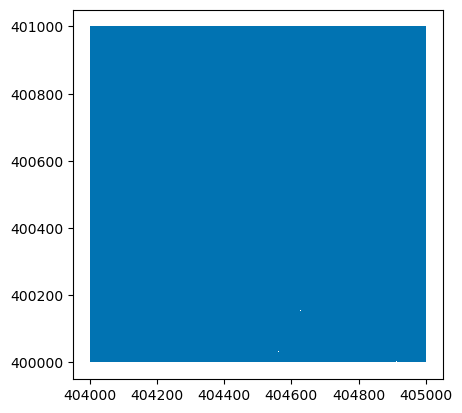

In [44]:
# pols_dict['d'].plot()
# tile
tmp = lca.load_pols([x for x in list_tiles_dict['e'] if 'SE0400' in x][0])
# tmp[tmp['lc_label'] != 'H2a'].plot()
tmp[tmp['lc_label'] == '0'].plot()

In [17]:
inds_sorted = np.argsort(pols_merged['geometry'].area)
pols_merged['area'] = pols_merged['geometry'].area
pols_merged = pols_merged.iloc[inds_sorted]
pols_merged

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,lc_label,source,geometry,Class name,area
2950,D3,model prediction,"POLYGON ((404183.625 400127.000, 404183.750 40...",Bracken,0.015625
81,F3a,model prediction,"POLYGON ((404337.750 400965.875, 404337.875 40...","Wetland, Peat Bog",0.015625
68,F3a,model prediction,"POLYGON ((404351.375 400970.250, 404351.500 40...","Wetland, Peat Bog",0.015625
2204,F3a,model prediction,"POLYGON ((404220.000 400315.875, 404220.125 40...","Wetland, Peat Bog",0.015625
2580,D1a,model prediction,"POLYGON ((404019.250 400243.125, 404019.375 40...",Upland Heath,0.015625
...,...,...,...,...,...
766,D1a,model prediction,"POLYGON ((404940.875 400993.000, 404943.500 40...",Upland Heath,33325.531250
1586,D1a,model prediction,"POLYGON ((404985.000 400794.250, 404985.375 40...",Upland Heath,45893.593750
3414,D6c,model prediction,"POLYGON ((404314.125 400754.125, 404314.250 40...",Upland Heath/Blanket Peat Mosaic,190147.031250
3428,F3a,model prediction,"POLYGON ((404000.000 401000.000, 404110.500 40...","Wetland, Peat Bog",555437.953125


In [7]:
## Step 2: merge all tiles into one file per section:
path_folder_complete_tiles = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/'
path_folder_sections = '/media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/merged_tiles_100kmsections/'

for section in tqdm(arr_sections):
    tiles_in_section = list(tile_outlines_tight[tile_outlines_tight[col_sections] == section]['PLAN_NO'])

    curr_dir_name = path_folder_complete_tiles.split('/') 
    curr_dir_name = curr_dir_name[-2] if curr_dir_name[-1] != '' else curr_dir_name[-3]  # in case dir_indiv_tile_shp ends with '/'
    # assert False, curr_dir_name
    filename_merger = f'merged_{curr_dir_name}_section-{section}.shp'

    lca.merge_individual_shp_files(dir_indiv_tile_shp=path_folder_complete_tiles, 
                                    delete_individual_shp_files=False,
                                    list_tile_ids_to_merge=tiles_in_section,
                                    filename=filename_merger,
                                    dir_save_merger=path_folder_sections)
    

  0%|          | 0/26 [00:00<?, ?it/s]

Found 95/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 95 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/



0it [00:00, ?it/s]

95it [00:20,  4.71it/s]
  4%|▍         | 1/26 [01:09<29:03, 69.73s/it]

Found 12/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 12 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


12it [00:04,  2.91it/s]
  8%|▊         | 2/26 [01:22<14:33, 36.40s/it]

Found 51/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 51 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


51it [00:11,  4.39it/s]
 12%|█▏        | 3/26 [01:58<13:54, 36.30s/it]

Found 3/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 3 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


3it [00:00,  6.38it/s]
 15%|█▌        | 4/26 [02:01<08:23, 22.89s/it]

Found 58/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 58 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


58it [00:16,  3.55it/s]
 19%|█▉        | 5/26 [02:52<11:36, 33.14s/it]

Found 56/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 56 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


56it [00:14,  3.73it/s]
 23%|██▎       | 6/26 [03:43<13:03, 39.20s/it]

Found 19/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 19 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


19it [00:04,  4.20it/s]
 27%|██▋       | 7/26 [04:01<10:10, 32.14s/it]

Found 67/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 67 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


67it [00:16,  3.95it/s]
 31%|███       | 8/26 [05:00<12:16, 40.94s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


100it [00:28,  3.55it/s]
 35%|███▍      | 9/26 [06:30<15:53, 56.08s/it]

Found 69/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 69 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


69it [00:18,  3.72it/s]
 38%|███▊      | 10/26 [07:39<16:01, 60.08s/it]

Found 76/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 76 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


76it [00:21,  3.52it/s]
 42%|████▏     | 11/26 [08:48<15:42, 62.82s/it]

Found 85/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 85 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


85it [00:21,  4.00it/s]
 46%|████▌     | 12/26 [09:59<15:13, 65.25s/it]

Found 1/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 1 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


1it [00:00,  2.54it/s]
 50%|█████     | 13/26 [10:00<09:57, 45.94s/it]

Found 17/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 17 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


17it [00:04,  3.61it/s]
 54%|█████▍    | 14/26 [10:15<07:19, 36.60s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


100it [00:22,  4.44it/s]
 58%|█████▊    | 15/26 [11:23<08:24, 45.87s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


100it [00:17,  5.64it/s]
 62%|██████▏   | 16/26 [12:07<07:34, 45.48s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


100it [00:22,  4.48it/s]
 65%|██████▌   | 17/26 [13:04<07:20, 48.97s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


100it [00:24,  4.11it/s]
 69%|██████▉   | 18/26 [14:23<07:43, 57.91s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


100it [00:23,  4.25it/s]
 73%|███████▎  | 19/26 [15:33<07:10, 61.44s/it]

Found 40/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 40 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


40it [00:11,  3.54it/s]
 77%|███████▋  | 20/26 [16:09<05:24, 54.02s/it]

Found 82/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 82 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


82it [00:25,  3.16it/s]
 81%|████████  | 21/26 [17:23<04:59, 59.99s/it]

Found 100/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 100 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


100it [00:29,  3.44it/s]
 85%|████████▍ | 22/26 [18:55<04:37, 69.49s/it]

Found 92/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 92 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


92it [00:25,  3.61it/s]
 88%|████████▊ | 23/26 [20:15<03:38, 72.79s/it]

Found 76/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 76 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


76it [00:23,  3.28it/s]
 92%|█████████▏| 24/26 [21:24<02:22, 71.47s/it]

Found 8/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 8 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


8it [00:02,  3.50it/s]
 96%|█████████▌| 25/26 [21:35<00:53, 53.53s/it]

Found 10/1617 tiles in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/ with tile ids
Merging 10 tiles found in /media/data-hdd/gis_pd/predictions/all_tiles_pd_dissolved/predictions_LCU_detailed-combined/individual_tiles/


10it [00:05,  1.88it/s]
100%|██████████| 26/26 [21:51<00:00, 50.43s/it]


In [2]:
# total_area_dict

## Create 100km^2 grids for different mergers:

In [23]:
outline_pd = lca.load_pols(path_dict['pd_outline'])
outline_pd = outline_pd.iloc[0]['geometry']
all_tiles = lca.load_pols(path_dict['landscape_character_grid_path'])
all_tiles = all_tiles[all_tiles['geometry'].intersects(outline_pd)]
all_tiles = all_tiles.reset_index(drop=True)
assert len(all_tiles) == 1617

In [24]:
# all_tiles['COUNTY'].unique()
## tiles per county:
n_tiles_per_county = all_tiles.groupby('COUNTY').size()
n_tiles_per_county

COUNTY
CHESHIR    108
DERBYSH    993
GT MAN      32
SOUTHYO    194
STAFFOR    229
WESTYOR     61
dtype: int64

In [25]:
all_tiles['100_grid'] = all_tiles['PLAN_NO'].apply(lambda x: x[:3] + x[4])

In [26]:
all_tiles['100_grid'].unique()

array(['SE00', 'SE01', 'SE10', 'SE20', 'SJ96', 'SJ97', 'SJ98', 'SK05',
       'SK06', 'SK07', 'SK08', 'SK09', 'SK04', 'SK14', 'SK15', 'SK16',
       'SK17', 'SK18', 'SK19', 'SK25', 'SK26', 'SK27', 'SK28', 'SK29',
       'SK36', 'SK37'], dtype=object)

In [27]:
all_tiles.to_file('/home/thijs/repos/cnn-land-cover/content/landscape_character_grid/Landscape_Character_Grid_tight.shp')